In [62]:
# Toy linear vorticity model (copyright: Naoko Sakaeda 2020)

In [3]:
# This cell imports all necessary libraries for this code
import xarray as xr # library for loading netcdf files
import matplotlib.pyplot as plt # library for plotting 
import numpy as np # libary for working with arrays
import cartopy.crs as ccrs # library for plotting on maps
import matplotlib.ticker as mticker # library for putting axes labels
import math # math library
from matplotlib import gridspec
from scipy import interpolate
import warnings
warnings.simplefilter("ignore")

In [4]:
# !!!!! parameters (change parameters here) !!!!!

# environmental flow parameter
opt_flow = 4
# set opt_flow = 0 to create uniform zonal flow
# set opt_flow = 1 to create non-uniform zonal flow

# baroclinic parameter
opt_baroclinic = 0;
# set opt_baroclinic = 0 to create barotropic fluid
# set opt_baroclinic = 1 to create baroclinic fluid

# scale for the size of vorticity
opt_vortsize = 1
# range between 0 to 1 to change the size of vorticity
# 0 would make the radius 200 km, 1 would make it 500 km

# scale for the environmental flow speed and direction
opt_U = -2
# range from -1 to 1 to change the speed and direction of environmental flow
# Recommended to set it as less than -0.2 or greater than 0.2
# -1 would make it easterly at 10 m/s, 1 would be 10 m/s westerly

In [5]:
# other parameters (!!! do not change this cell !!!) 

# create idealized uniform flow in normalized axes
# define domain size
int_xy = 10*10**3 # domain resolution (m)
x = np.arange(-1000*10**3,1000*10**3+int_xy,int_xy,dtype='float') # meters
y = np.arange(-500*10**3,500*10**3+int_xy,int_xy,dtype='float') # meters
x_mesh, y_mesh = np.meshgrid(x,y) # (m) y-by-x dimension
dx = x+int_xy - x # grid distance
dy = y+int_xy - y
dx_mesh,dy_mesh = np.meshgrid(dx,dy)
del dx 
del dy
area_grid = dy_mesh*dx_mesh # area of each grid (m^2, uniform grid area)

# set coefficients
R = 287.0 # gas constant
pi = math.pi

# define mean zonal environmental flow
Umax = 10.0 # m/s
if opt_U < -1:
    opt_U = -1
elif opt_U > 1:
    opt_U = 1
U = opt_U*Umax

# define perturbation vorticity amplitude and radius
vort_amp = 1*10**-4; # s^-1
vort_radius_min = 200*10**3; # radius of the vorticity (m)
if opt_vortsize<0:
    opt_vortsize=0
elif opt_vortsize>1:
    opt_vortsize=1
vort_radius = vort_radius_min + (opt_vortsize*(np.max(y)-vort_radius_min))

# create vorticity
radius = (x_mesh**2 + y_mesh**2)**0.5
vort = np.zeros((len(y),len(x)))
vort = np.where(radius<=vort_radius, vort_amp*np.cos((pi/2)*radius/vort_radius), vort)
# smooth the vorticity
vort[:,:] = (2*vort + np.roll(vort,1,axis=1) + np.roll(vort,-1,axis=1))/4
temp=(2*vort[np.array([0,-1]),:]+vort[np.array([1,-2]),:])/3
vort[1:-1,:] = (2*vort[1:-1,:]+vort[2:,:]+vort[0:-2,:])/4
vort[np.array([0,-1]),:]=temp
del temp

# define material square box
materialW = -1*vort_radius-100*10**3 # west bound
materialE = vort_radius+100*10**3 # east bound
materialN = np.min((y[-1],vort_radius+100*10**3)) # north bound
materialS = np.max((y[0],-1*vort_radius-100*10**3)) # south bound

# environmental wind
v_env = np.zeros((len(y),len(x)))
# amplitude of the zonal flow variability
amp_divg = 0.1 # between -1 to 1 (>0 for divergence at east, <0 for convergence at east, 0: no divergence)
if opt_flow == 0:
    # uniform zonal flow
    u_env = U*np.ones((len(y),len(x)))
else:
    # non-uniform flow   
    u_env = U - amp_divg*Umax*np.cos(2*pi*x_mesh/(x[-1]-x[1]+int_xy))

# environmental pressure, temperature, and density
amp_dp = 1000 # Pa (amplitude of pressure variability)
amp_dT = 10 # (amplitude of pressure variability)
p_base = 1000*10**2 # Pa (reference pressure)
T_base = 273.15+13 # K (reference temperature)
# zonally uniform, meridionally varing pressure
p_env = p_base-np.tile(y*(amp_dp/(2*vort_radius)),(len(x),1)).T
test = p_base-vort_radius*(amp_dp/(2*vort_radius))
p_env = np.where(y_mesh>=vort_radius, p_base-vort_radius*(amp_dp/(2*vort_radius)), p_env)
p_env = np.where(y_mesh<=-1*vort_radius, p_base+vort_radius*(amp_dp/(2*vort_radius)), p_env)
# parameters for baroclinic environment
T_angle = 45 # deg (angle of temperature gradient)
T_xctr = 500*10**3 # (m) x-point where temperature gradient crosses y=0
if opt_baroclinic == 0:
    # barotropic environment
    # T_env = T_base*np.ones(length(y),length(x)); #constant temperature
    T_env = T_base - y_mesh*(amp_dT/(2*vort_radius))
    T_env = np.where(y_mesh>=vort_radius, T_base-vort_radius*(amp_dT/(2*vort_radius)), T_env)
    T_env = np.where(y_mesh<=-1*vort_radius, T_base+vort_radius*(amp_dT/(2*vort_radius)), T_env)
else:
    # baroclinic environment
    T_env = T_base*np.ones((len(y),len(x)))
    # create temperature variability east of the center
    T_env = np.where(x_mesh>0, T_env+amp_dT*np.sin(2*pi*x_mesh/(x[-1]-x[0]+int_xy)), T_env)

# density
rho_env = p_env/(R*T_env);
amp_drho = (p_base+amp_dp)/(R*T_base-amp_dT) - (p_base-amp_dp)/(R*T_base+amp_dT)
amp_baroclinic = abs((0.5*amp_dp/vort_radius)*(0.5*amp_drho/vort_radius)*(T_xctr/Umax)*(2*vort_radius+100*10**3)*(2*vort_radius))


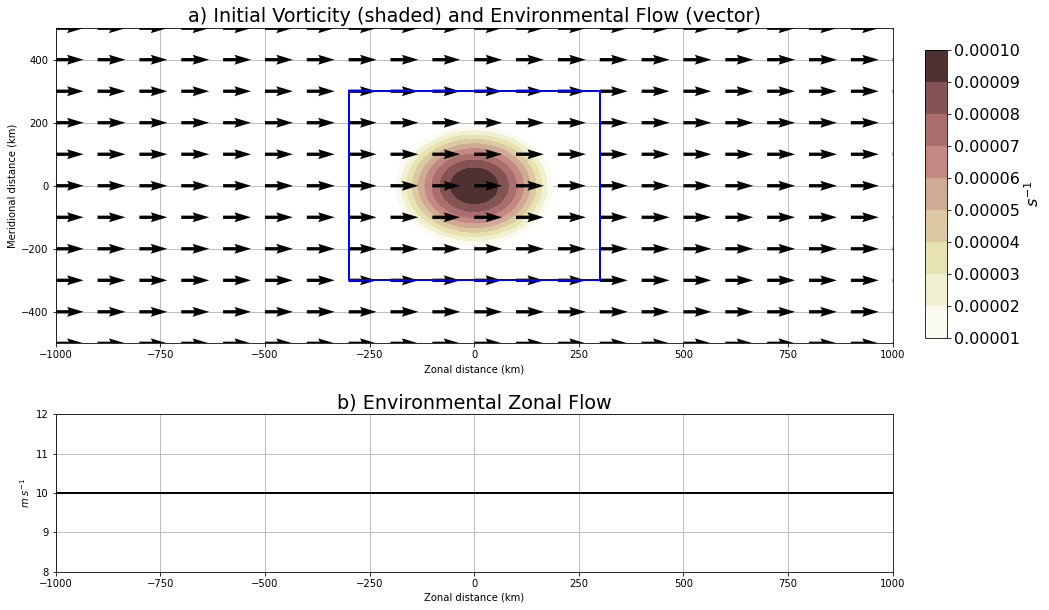

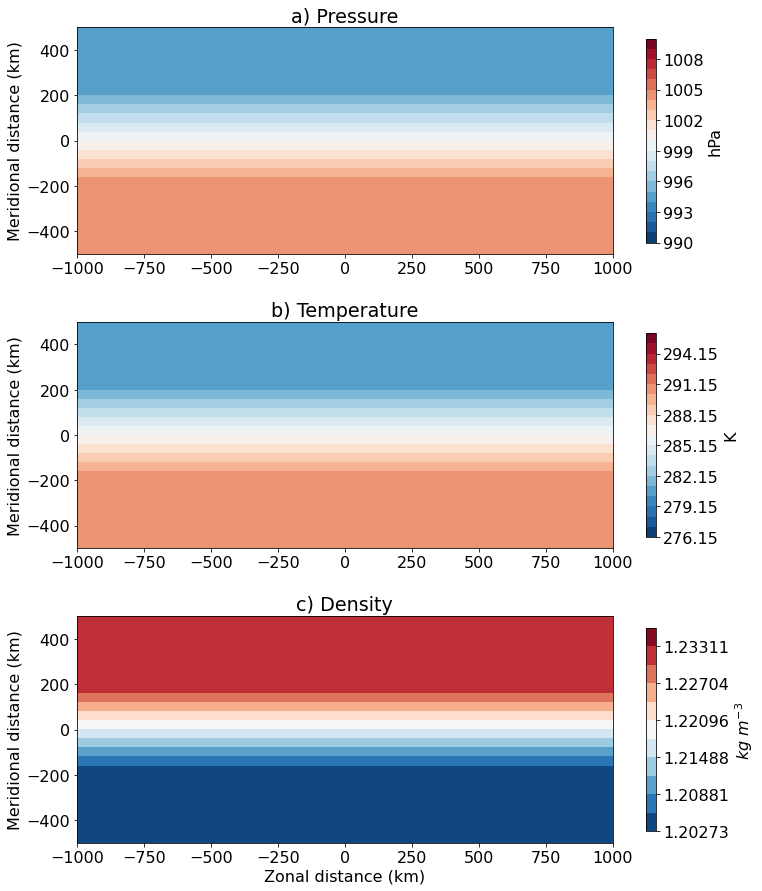

In [6]:
# plot environmental flow and initial vorticity

# scale for vectors
vscale = 30*np.mean((u_env**2+v_env**2))**0.5
vplot_int = 10 # grid interval to plot wind vectors
                      
fig, axs = plt.subplots(2, 1, figsize=(15,10), gridspec_kw={'height_ratios': [2, 1]}) # create a figure
plt.rcParams.update({'font.size':16}) # change the font size
# plot filled contours (vorticity)
ticks = np.arange(vort_amp/10,vort_amp+vort_amp/10,vort_amp/10)
plot1 = axs[0].contourf(x*10**-3,y*10**-3,np.where(vort>ticks[-1],ticks[-1],vort),ticks,cmap='pink_r',zorder=2) 
axcbar = fig.add_axes([0.93,0.45,0.02,0.4])
cbar = fig.colorbar(plot1,shrink=0.8,cax=axcbar) # add a colorbar
cbar.set_label('$s^{-1}$') # add units label to the colorbar
# add vectors
plot2 = axs[0].quiver(10**-3*x_mesh[::vplot_int,::vplot_int],10**-3*y_mesh[::vplot_int,::vplot_int],\
                  u_env[::vplot_int,::vplot_int],v_env[::vplot_int,::vplot_int],\
                  scale=vscale,zorder=3)
# add material curve
plot1a = axs[0].plot(np.array((materialW,materialE))*10**-3,materialS*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)
plot1b = axs[0].plot(np.array((materialW,materialE))*10**-3,materialN*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)
plot1c = axs[0].plot(materialW*np.array((1,1))*10**-3,np.array((materialN,materialS))*10**-3,color='b',linewidth=2,zorder=4)
plot1d = axs[0].plot(materialE*np.array((1,1))*10**-3,np.array((materialN,materialS))*10**-3,color='b',linewidth=2,zorder=4)
# add title
axs[0].set_title('a) Initial Vorticity (shaded) and Environmental Flow (vector)') 
axs[0].set_xlabel('Zonal distance (km)')
axs[0].set_ylabel('Meridional distance (km)')
axs[0].grid(True)
# plot environmental zonal flow
ylimit0 = U+np.array([-1,1])*(amp_divg+0.1)*Umax
plot3 = axs[1].plot(x*10**-3,np.nanmean(u_env,axis=0),color='k',linewidth=2,zorder=3)
axs[1].set_xlim(x[np.array([0,-1])]*10**-3)
axs[1].set_ylim(ylimit0)
axs[1].set_title('b) Environmental Zonal Flow') 
axs[1].set_xlabel('Zonal distance (km)')
axs[1].set_ylabel('$m\ s^{-1}$')
plt.subplots_adjust(hspace=0.3)
axs[1].grid(True)


# pressure, temperature, and density field
fig, axs = plt.subplots(3, 1, figsize=(12,15)) # create a figure
plt.subplots_adjust(hspace=0.3)
ticks = (p_base+np.arange(-amp_dp,amp_dp+amp_dp/10,amp_dp/10))*10**-2
plot1 = axs[0].contourf(x*10**-3,y*10**-3,p_env*10**-2,ticks,cmap='RdBu_r',zorder=2) 
cbar = fig.colorbar(plot1,shrink=0.9,ax=axs[0])
cbar.set_label('hPa')
axs[0].set_title('a) Pressure') 
axs[0].set_ylabel('Meridional distance (km)')
axs[0].grid(True)
ticks = (T_base+np.arange(-amp_dT,amp_dT+amp_dT/10,amp_dT/10))
plot1 = axs[1].contourf(x*10**-3,y*10**-3,T_env,ticks,cmap='RdBu_r',zorder=2) 
cbar = fig.colorbar(plot1,shrink=0.9,ax=axs[1])
cbar.set_label('K')
axs[1].set_title('b) Temperature') 
axs[1].set_ylabel('Meridional distance (km)')
axs[1].grid(True)
rho_int = (np.max(rho_env)-np.min(rho_env))/10
ticks = np.arange(np.min(rho_env),np.max(rho_env)+rho_int,rho_int)
plot1 = axs[2].contourf(x*10**-3,y*10**-3,rho_env,ticks,cmap='RdBu_r',zorder=2) 
cbar = fig.colorbar(plot1,shrink=0.9,ax=axs[2])
cbar.set_label('$kg\ m^{-3}$')
axs[2].set_title('c) Density') 
axs[2].set_xlabel('Zonal distance (km)')
axs[2].set_ylabel('Meridional distance (km)')
axs[2].grid(True)

In [7]:
# Run simple linear vorticity model (!!! do not change this section !!!) 
tint = 60 # (seconds) time interval (1 minutes)
tmax = 60*60*24*2 # iterate over two day (in seconds)

# output variables
time = np.arange(0,tmax+tint,tint) # time array
vort_output = np.zeros((len(time),len(y),len(x)))*np.nan # vorticity
adv_output = np.zeros((len(time),len(y),len(x)))*np.nan # total advection of vorticity
stretch_output = np.zeros((len(time),len(y),len(x)))*np.nan # stretching of vorticity
baroclinic_env = np.zeros((len(y),len(x)))*np.nan #baroclinic term (constant in time)
circ_output = np.zeros((len(time),1))*np.nan # circulation following a material square
materialE_output = np.zeros((len(time),1))*np.nan # eastern boundary of the material curve
materialW_output = np.zeros((len(time),1))*np.nan # western boundary
# only track east-west boundaries of the material curve because there is no
# meridional flow and the flow is meridionally uniform

# set initial state
vort_output[0,:,:]=vort;
materialE_output[0] = materialE;
materialW_output[0] = materialW;

# calculate baroclinic term
drhodx = np.zeros((len(y),len(x)))*np.nan
drhodx[:,:] = (np.roll(rho_env,-1,axis=1)-np.roll(rho_env,1,axis=1))/(2*dx_mesh)
drhody = np.zeros((len(y),len(x)))*np.nan
drhody[1:-1,:] = (rho_env[2:,:]-rho_env[0:-2,:])/(2*dy_mesh[1:-1,:])
drhody[np.array([0,-1]),:] = (rho_env[np.array([1,-1]),:]-rho_env[np.array([0,-2]),:])/(dy_mesh[np.array([0,-1]),:])
dpdx = np.zeros((len(y),len(x)))*np.nan
dpdx[:,:] = (np.roll(p_env,-1,axis=1)-np.roll(p_env,1,axis=1))/(2*dx_mesh)
dpdy = np.zeros((len(y),len(x)))*np.nan
dpdy[1:-1,:] = (p_env[2:,:]-p_env[0:-2,:])/(2*dy_mesh[1:-1,:])
dpdy[np.array([0,-1]),:] = (p_env[np.array([1,-1]),:]-p_env[np.array([0,-2]),:])/(dy_mesh[np.array([0,-1]),:])
baroclinic_env[:,:] = (rho_env**-2)*(drhodx*dpdy-drhody*dpdx)

# environmental divergence
divg_env = np.zeros((len(y),len(x)))*np.nan
divg_env[:,:] = (np.roll(u_env,-1,axis=1)-np.roll(u_env,1,axis=1))/(2*dx_mesh)
divg_env[1:-1,:] = divg_env[1:-1,:] + (v_env[2:,:]-v_env[0:-2,:])/(2*dy_mesh[1:-1,:])
divg_env[np.array([0,-1]),:] = divg_env[np.array([0,-1]),:] + (v_env[np.array([1,-1]),:]-v_env[np.array([0,-2]),:])/(dy_mesh[np.array([0,-1]),:])

# number of spatial smoothing
nsmooth = 5
# apply smoothing
for n in range(0,nsmooth):
    baroclinic_env[:,:] = (2*baroclinic_env + np.roll(baroclinic_env,-1,axis=1) + np.roll(baroclinic_env,1,axis=1))/4
    temp=(2*baroclinic_env[np.array([0,-1]),:]+baroclinic_env[np.array([1,-2]),:])/3
    baroclinic_env[1:-1,:] = (2*baroclinic_env[1:-1,:]+baroclinic_env[2:,:]+baroclinic_env[0:-2,:])/4
    baroclinic_env[np.array([0,-1]),:]=temp
    del temp

# extended domain width (need for interpolation)
x_ext = np.zeros(len(x)+2)
x_ext[1:-1]=x
x_ext[0]=x[0]-int_xy
x_ext[-1]=x[-1]+int_xy

# interate in time
for t in range(0,len(time)):
    # calculate advection
    adv_x = np.zeros((len(y),len(x)))*np.nan
    adv_x[:,:]=-1*u_env*(np.roll(vort_output[t,:,:],-1,axis=1)-np.roll(vort_output[t,:,:],1,axis=1))/(2*dx_mesh)
    adv_y = np.zeros((len(y),len(x)))*np.nan
    adv_y[1:-1,:] = -1*v_env[1:-1,:]*(vort_output[t,2:,:]-vort_output[t,0:-2,:])/(2*dy_mesh[1:-1,:])
    adv_y[np.array([0,-1]),:] = -1*v_env[np.array([0,-1]),:]*(vort_output[t,np.array([1,-1]),:]-vort_output[t,np.array([0,-2]),:])/(dy_mesh[np.array([0,-1]),:])
    adv = adv_x + adv_y
    del adv_x
    del adv_y
    # stretching
    stretch = -1*divg_env*vort_output[t,:,:]
    
    # apply smoothin
    for n in range(0,nsmooth):
        adv[:,:] = (2*adv + np.roll(adv,1,axis=1) + np.roll(adv,-1,axis=1))/4
        temp=(2*adv[np.array([0,-1]),:]+adv[np.array([1,-2]),:])/3
        adv[1:-1,:] = (2*adv[1:-1,:]+adv[2:,:]+adv[0:-2,:])/4
        adv[np.array([0,-1]),:]=temp
        del temp
        stretch[:,:] = (2*stretch + np.roll(stretch,1,axis=1) + np.roll(stretch,-1,axis=1))/4
        temp=(2*stretch[np.array([0,-1]),:]+stretch[np.array([1,-2]),:])/3
        stretch[1:-1,:] = (2*stretch[1:-1,:]+stretch[2:,:]+stretch[0:-2,:])/4
        stretch[np.array([0,-1]),:]=temp
        del temp
        
    # calculate local change in vorticity
    adv_output[t,:,:]=adv
    stretch_output[t,:,:]=stretch
    dvortdt = adv_output[t,:,:]+stretch_output[t,:,:]+baroclinic_env # s^-1
    
    # shift the x-dimension when the curve moves across the edges of the periodical domain
    if materialW_output[t] > x[-1]:
        materialW_output[t] = materialW_output[t]-(x[-1]-x[0]+int_xy)
    if materialW_output[t] < x[0]:
        materialW_output[t] = materialW_output[t]+(x[-1]-x[0]+int_xy)
    if materialE_output[t] > x[-1]:
        materialE_output[t] = materialE_output[t]-(x[-1]-x[0]+int_xy)
    if materialE_output[t] < x[0]:
        materialE_output[t] = materialE_output[t]+(x[-1]-x[0]+int_xy)
    # find the area bounded by the material curve
    if materialW_output[t]>materialE_output[t]:
        grid_material = np.where(((x_mesh>=materialW_output[t]) | (x_mesh<=materialE_output[t])) & (y_mesh>=materialS) & (y_mesh<=materialN), 1, 0)
    else:
        grid_material = np.where((x_mesh>=materialW_output[t]) & (x_mesh<=materialE_output[t]) & (y_mesh>=materialS) & (y_mesh<=materialN), 1, 0)
    
    # calculate circulation using Stokes Theorem
    circ_output[t] = (np.sum(vort_output[t,:,:]*grid_material)/np.sum(grid_material))*np.sum(area_grid*grid_material)
    
    # calculate vorticity and material curve boundaries at the next time step
    if t<len(time)-1:
        # find zonal wind speed at the current location of the material curve
        u_ext = np.zeros(len(x)+2)
        u_ext[1:-1] = u_env[y==0,:]
        u_ext[0] = u_env[y==0,-1]
        u_ext[-1] = u_env[y==0,0]
        u_interp = interpolate.interp1d(x_ext, u_ext)
        U_materialW = u_interp(materialW_output[t])
        U_materialE = u_interp(materialE_output[t])
        del u_interp
        del u_ext
        materialW_output[t+1] = materialW_output[t]+U_materialW*tint 
        materialE_output[t+1] = materialE_output[t]+U_materialE*tint
        del U_materialW
        del U_materialE
        # integrate vorticity in time
        vort_new = vort_output[t,:,:]+dvortdt*tint
        vort_output[t+1,:,:]=vort_new
        del vort_new
        
# smooth circulation output
for n in range(1,100):
    temp=(2*circ_output[np.array([0,-1])]+circ_output[np.array([1,-2])])/3
    circ_output[1:-1] = (2*circ_output[1:-1]+circ_output[2:]+circ_output[0:-2])/4
    circ_output[np.array([0,-1]),:]=temp
    del temp
    

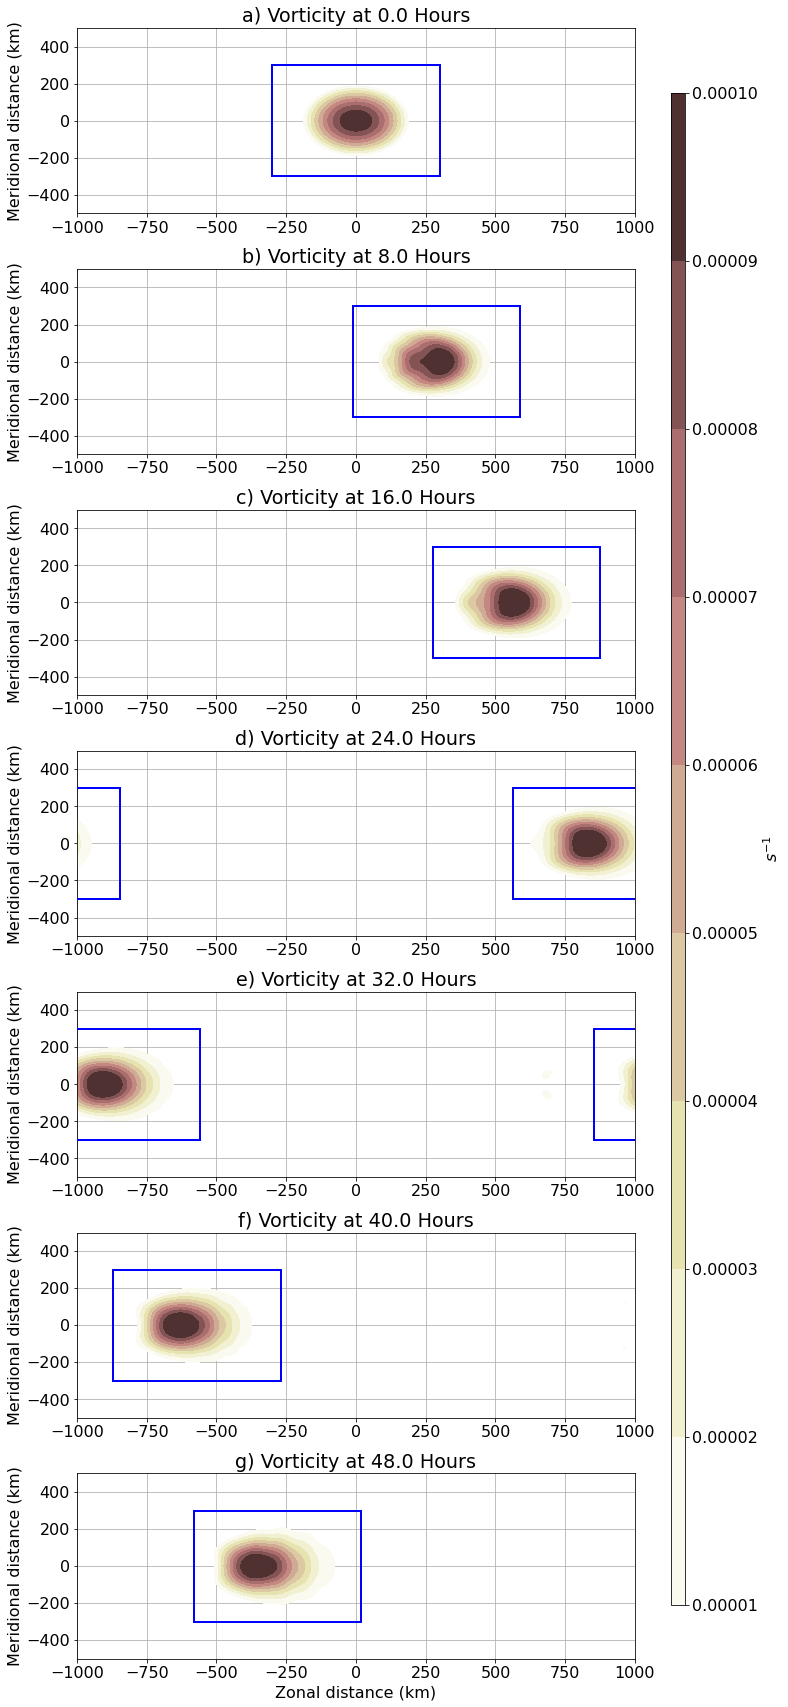

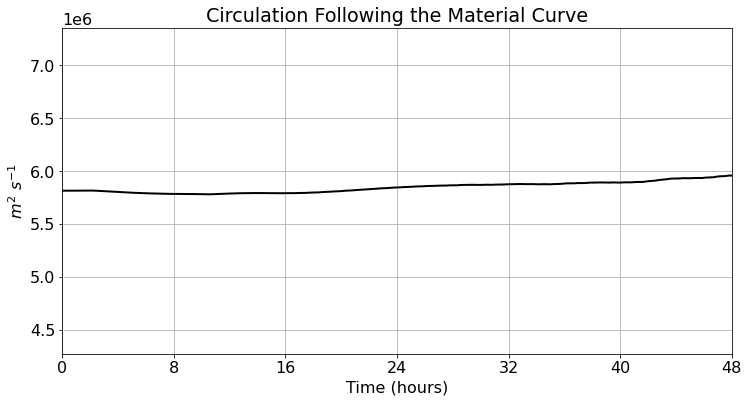

In [8]:
# plot model output
# x-y plots of vorticity at every 8 hours
fig, axs = plt.subplots(7, 1, figsize=(10,30)) # create a figure
plt.subplots_adjust(hspace=0.4)
plot_tint = np.where(np.isin(time,np.arange(0,(48+8)*3600,8*3600)))[0]
ticks = np.arange(vort_amp/10,vort_amp+vort_amp/10,vort_amp/10)
axcbar = fig.add_axes([0.95,0.15,0.02,0.7])
plt.subplots_adjust(hspace=0.3)
alphabet = ['a','b','c','d','e','f','g','h']
for t in range(0,len(plot_tint)):
    # plot filled contours (vorticity)
    plot1 = axs[t].contourf(x*10**-3,y*10**-3,np.where(vort_output[plot_tint[t],:,:]>ticks[-1],ticks[-1],vort_output[plot_tint[t],:,:]),ticks,cmap='pink_r',zorder=2) 
    # add material curve
    if materialW_output[plot_tint[t]]>materialE_output[plot_tint[t]]:
        plot1a = axs[t].plot(np.array((materialW_output[plot_tint[t]]*10**-3,x[-1]*10**-3)),materialS*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)
        plot1b = axs[t].plot(np.array((materialW_output[plot_tint[t]]*10**-3,x[-1]*10**-3)),materialN*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)        
        plot1aa = axs[t].plot(np.array((x[0]*10**-3,materialE_output[plot_tint[t]]*10**-3)),materialS*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)
        plot1ba = axs[t].plot(np.array((x[0]*10**-3,materialE_output[plot_tint[t]]*10**-3)),materialN*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)        
    else:
        plot1a = axs[t].plot(np.array((materialW_output[plot_tint[t]],materialE_output[plot_tint[t]]))*10**-3,materialS*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)
        plot1b = axs[t].plot(np.array((materialW_output[plot_tint[t]],materialE_output[plot_tint[t]]))*10**-3,materialN*np.array((1,1))*10**-3,color='b',linewidth=2,zorder=4)
    plot1c = axs[t].plot(materialW_output[plot_tint[t]]*np.array((1,1))*10**-3,np.array((materialN,materialS))*10**-3,color='b',linewidth=2,zorder=4)
    plot1d = axs[t].plot(materialE_output[plot_tint[t]]*np.array((1,1))*10**-3,np.array((materialN,materialS))*10**-3,color='b',linewidth=2,zorder=4)
    # add title
    axs[t].set_title(alphabet[t]+') Vorticity at '+str(time[plot_tint[t]]/3600)+' Hours')
    axs[t].set_ylabel('Meridional distance (km)')
    axs[t].grid(True)
axs[len(plot_tint)-1].set_xlabel('Zonal distance (km)')
cbar = fig.colorbar(plot1,shrink=0.8,cax=axcbar) # add a colorbar
cbar.set_label('$s^{-1}$') # add units label to the colorbar


# plot circulation
fig = plt.figure(figsize=(12,6)) # create a figure
plot1 = plt.plot(time/3600,circ_output,color='k',linewidth=2)
plt.xlim(time[np.array([0,-1])]/3600)
plt.xticks(np.arange(0,(48+8),8))
plt.ylim(circ_output[0]+np.array([-1,1])*amp_baroclinic)
plt.title('Circulation Following the Material Curve') 
plt.xlabel('Time (hours)')
plt.ylabel('$m^{2}\ s^{-1}$')
plt.subplots_adjust(hspace=0.3)
plt.grid(True)

In [9]:
## model output variables that you can use for further analysis
#
# dimensions:
# x: x-dimension (in meters from the center of the domain)
# y: y-dimension (in meters from the center of the domain)
# time: time dimension (in seconds since the initialization)
#
# environmental variables:
# u_env(y,x): environmental zonal wind (m/s)
# v_env(y,x): environmental meridional wind (m/s)
# p_env(y,x): pressure (Pa)
# T_env(y,x): temperature (K)
# rho_env(y,x): density (kg/m^3)
#
# model output variables:
# vort_output(time,y,x): vorticity (per second)
# adv_output(time,y,x): total advection of vorticity
# stretch_output(time,y,x): stretching term
# baroclinic_env(y,x): baroclinic term (constant in time)
# circ_output(time):  circulation following a material curve (m^2 s^-1)